<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Histogram**


Estimated time needed: **45** minutes


In this lab, you will focus on the visualization of data. The dataset will be provided through an RDBMS, and you will need to use SQL queries to extract the required data.


## Objectives


In this lab, you will perform the following:


- Visualize the distribution of data using histograms.

- Visualize relationships between features.

- Explore data composition and comparisons.


## Demo: Working with database


#### Download the database file.


In [1]:
# !wget -O survey-data.sqlite https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/QR9YeprUYhOoLafzlLspAw/survey-results-public.sqlite

In [2]:
import urllib.request

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/QR9YeprUYhOoLafzlLspAw/survey-results-public.sqlite"
urllib.request.urlretrieve(url, "survey-data.sqlite")
print("Downloaded to survey-data.sqlite")

Downloaded to survey-data.sqlite


#### Install the required libraries and import them


In [3]:
!pip install pandas

In [4]:
!pip install matplotlib

In [5]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

#### Connect to the SQLite database


In [6]:
conn = sqlite3.connect('survey-data.sqlite')

## Demo: Basic SQL queries

**Demo 1: Count the number of rows in the table**


In [7]:
QUERY = "SELECT COUNT(*) FROM main"
df = pd.read_sql_query(QUERY, conn)
print(df)


   COUNT(*)
0     65437


**Demo 2: List all tables**


In [8]:
QUERY = """
SELECT name as Table_Name 
FROM sqlite_master 
WHERE type = 'table'
"""
pd.read_sql_query(QUERY, conn)


,Table_Name
0,main


**Demo 3: Group data by age**


In [9]:
QUERY = """
SELECT Age, COUNT(*) as count 
FROM main 
GROUP BY Age 
ORDER BY Age
"""
df_age = pd.read_sql_query(QUERY, conn)
print(df_age)


                  Age  count
0     18-24 years old  14098
1     25-34 years old  23911
2     35-44 years old  14942
3     45-54 years old   6249
4     55-64 years old   2575
5   65 years or older    772
6   Prefer not to say    322
7  Under 18 years old   2568


## Hands-on Lab: Visualizing Data with Histograms


### 1. Visualizing the distribution of data (Histograms)


**1.1 Histogram of `CompTotal` (Total Compensation)**


Objective: Plot a histogram of `CompTotal` to visualize the distribution of respondents' total compensation.


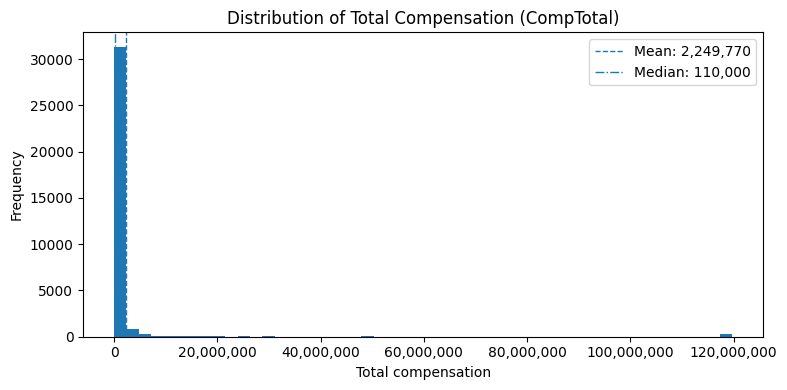

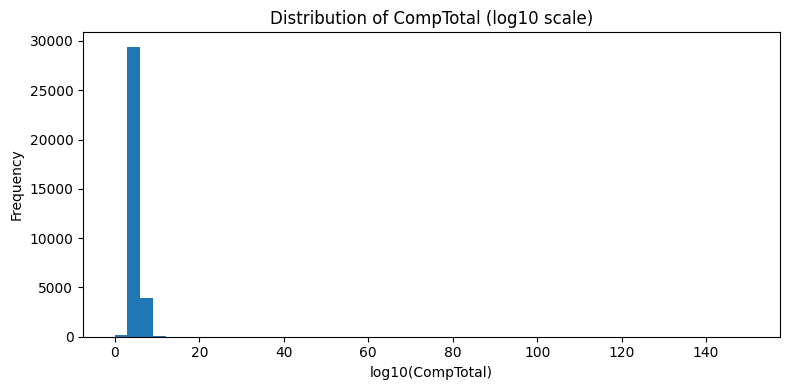

In [10]:
## Write your code here
# Option 1: CompTotal
# %%
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# --- Connect & extract only what we need (as numeric) ---
conn = sqlite3.connect("survey-data.sqlite")
QUERY = """
SELECT CAST(CompTotal AS REAL) AS CompTotal
FROM main
WHERE CompTotal IS NOT NULL
  AND TRIM(CAST(CompTotal AS TEXT)) <> ''
  AND CAST(CompTotal AS REAL) > 0
"""
comp = pd.read_sql_query(QUERY, conn)
conn.close()

# Ensure numeric (defensive) and drop NAs
comp["CompTotal"] = pd.to_numeric(comp["CompTotal"], errors="coerce")
comp = comp.dropna(subset=["CompTotal"])

# Focus on central 99% to avoid a long right tail dominating the plot
low, high = comp["CompTotal"].quantile([0.01, 0.99])
x = comp["CompTotal"].clip(lower=low, upper=high)

mean_val = x.mean()
median_val = x.median()

# --- Plot: Histogram of CompTotal (central 99%) ---
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(x, bins=50)
ax.axvline(mean_val, linestyle="--", linewidth=1, label=f"Mean: {mean_val:,.0f}")
ax.axvline(median_val, linestyle="-.", linewidth=1, label=f"Median: {median_val:,.0f}")
ax.set_title("Distribution of Total Compensation (CompTotal)")
ax.set_xlabel("Total compensation")
ax.set_ylabel("Frequency")
ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{int(v):,}"))
ax.legend()
plt.tight_layout()
plt.show()

# --- Optional: log-scale view for the full range (helps with very long tails) ---
comp_pos = comp.loc[comp["CompTotal"] > 0, "CompTotal"]
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(np.log10(comp_pos), bins=50)
ax.set_title("Distribution of CompTotal (log10 scale)")
ax.set_xlabel("log10(CompTotal)")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

Median: 65,000 | 1st pct: 208 | 99th pct: 393,751


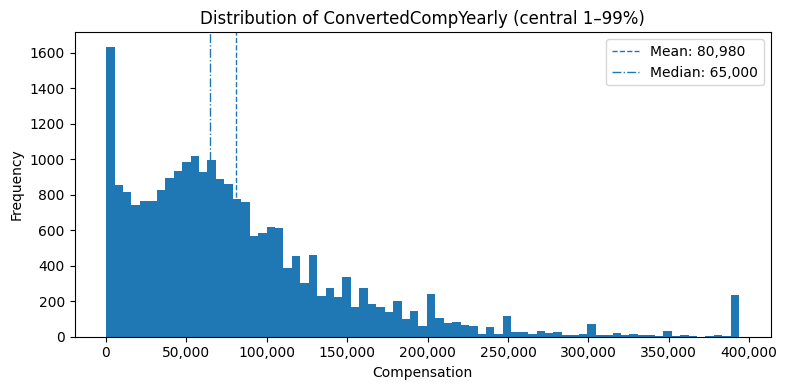

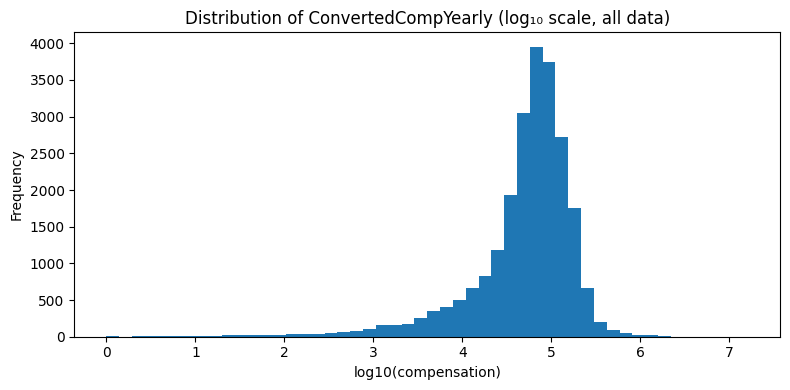

In [11]:
# Option 2:ConvertedCompYearly

import sqlite3, pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

conn = sqlite3.connect("survey-data.sqlite")

# 1) Try a normalized yearly column if it exists; else fall back to CompTotal
cols = pd.read_sql_query("PRAGMA table_info('main');", conn)['name'].tolist()
target_col = 'ConvertedCompYearly' if 'ConvertedCompYearly' in cols else 'CompTotal'

q = f"""
SELECT CAST({target_col} AS REAL) AS comp
FROM main
WHERE {target_col} IS NOT NULL
  AND TRIM(CAST({target_col} AS TEXT)) <> ''
  AND CAST({target_col} AS REAL) > 0
"""
comp = pd.read_sql_query(q, conn)['comp'].astype(float)
conn.close()

# Quick sanity: robust stats
p01, p50, p99 = comp.quantile([0.01, 0.50, 0.99])
print(f"Median: {p50:,.0f} | 1st pct: {p01:,.0f} | 99th pct: {p99:,.0f}")

# 2) Trim to central 1–99% for a readable histogram
x = comp.clip(lower=p01, upper=p99)
mean_v, med_v = x.mean(), x.median()

fig, ax = plt.subplots(figsize=(8,4))
ax.hist(x, bins='fd')  # Freedman–Diaconis for sensible bin width
ax.axvline(mean_v, linestyle='--', linewidth=1, label=f"Mean: {mean_v:,.0f}")
ax.axvline(med_v, linestyle='-.', linewidth=1, label=f"Median: {med_v:,.0f}")
ax.set_title(f"Distribution of {target_col} (central 1–99%)")
ax.set_xlabel("Compensation")
ax.set_ylabel("Frequency")
ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{int(v):,}"))
ax.legend()
plt.tight_layout(); plt.show()

# 3) Full population, but on log10 scale
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(np.log10(comp), bins=50)
ax.set_title(f"Distribution of {target_col} (log₁₀ scale, all data)")
ax.set_xlabel("log10(compensation)")
ax.set_ylabel("Frequency")
plt.tight_layout(); plt.show()

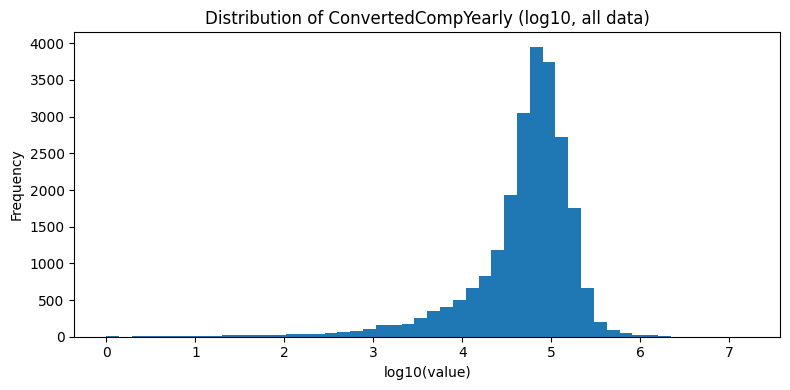

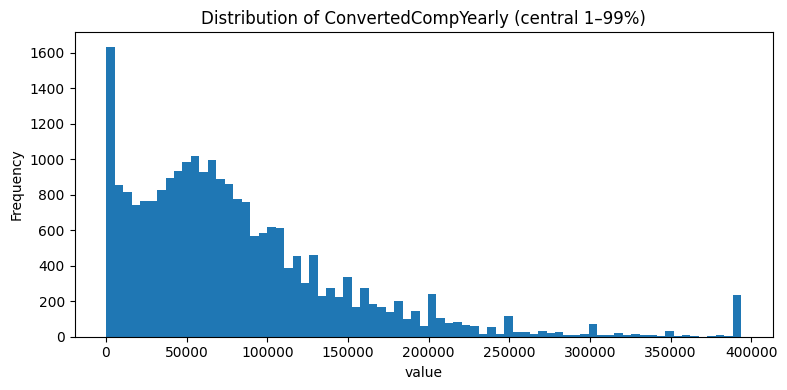

count     23435.000000
mean      80980.245867
std       69386.212612
min         207.680000
25%       32712.000000
50%       65000.000000
75%      107971.500000
max      393751.060000
Name: val, dtype: float64

In [12]:
# Option 3: The log-scale version is great for income data
import sqlite3, pandas as pd, numpy as np, matplotlib.pyplot as plt

def hist_from_sql(db="survey-data.sqlite", table="main", col="ConvertedCompYearly",
                  trim=(0.00, 1.00), log10=False, bins=50, title=None):
    conn = sqlite3.connect(db)
    q = f"""
    SELECT CAST({col} AS REAL) AS val
    FROM {table}
    WHERE {col} IS NOT NULL
      AND TRIM(CAST({col} AS TEXT)) <> ''
      AND CAST({col} AS REAL) > 0
    """
    s = pd.read_sql_query(q, conn)['val'].astype(float)
    conn.close()

    # optional trimming for readability
    lo, hi = s.quantile([trim[0], trim[1]])
    s = s.clip(lower=lo, upper=hi)

    x = np.log10(s) if log10 else s
    fig, ax = plt.subplots(figsize=(8,4))
    ax.hist(x, bins=bins)
    ax.set_title(title or (f"{col} (log10)" if log10 else f"{col}"))
    ax.set_xlabel("log10(value)" if log10 else "value")
    ax.set_ylabel("Frequency")
    plt.tight_layout(); plt.show()
    return s.describe()

# Examples
hist_from_sql(col="ConvertedCompYearly", trim=(0.00, 1.00), log10=True, bins=50,
              title="Distribution of ConvertedCompYearly (log10, all data)")

# If you ever need the trimmed linear view:
hist_from_sql(col="ConvertedCompYearly", trim=(0.01, 0.99), log10=False, bins='fd',
              title="Distribution of ConvertedCompYearly (central 1–99%)")


**1.2 Histogram of YearsCodePro (Years of Professional Coding Experience)**


Objective: Plot a histogram of `YearsCodePro` to analyze the distribution of coding experience among respondents.


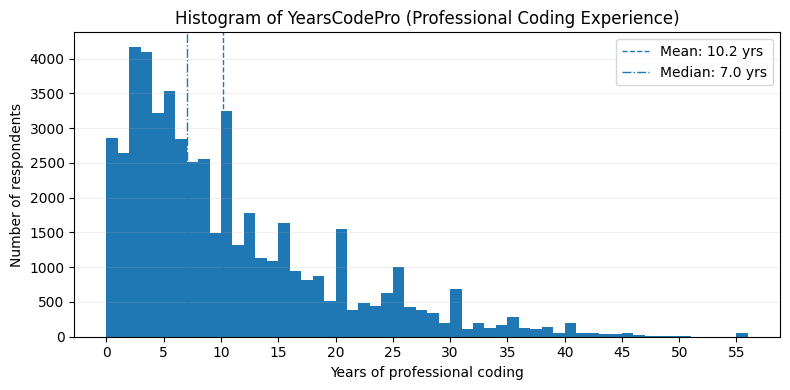

In [13]:
## Write your code here
# %%
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load YearsCodePro from SQLite ---
conn = sqlite3.connect("survey-data.sqlite")
QUERY = """
SELECT YearsCodePro
FROM main
WHERE YearsCodePro IS NOT NULL
  AND TRIM(YearsCodePro) <> ''
"""
s = pd.read_sql_query(QUERY, conn)["YearsCodePro"].astype(str).str.strip()
conn.close()

# --- Normalize to numeric ---
# Map common text values; coerce everything else to numbers
s = s.replace({
    "Less than 1 year": 0.5,
    "More than 50 years": 55
})
years = pd.to_numeric(s, errors="coerce").dropna()

# Keep plausible range for experience
years = years[years.between(0, 60)]

mean_v, med_v = years.mean(), years.median()

# --- Plot: 1-year bins with mean/median lines ---
bins = np.arange(0, np.floor(years.max()) + 2, 1)

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(years, bins=bins)
ax.axvline(mean_v, linestyle="--", linewidth=1, label=f"Mean: {mean_v:.1f} yrs")
ax.axvline(med_v, linestyle="-.", linewidth=1, label=f"Median: {med_v:.1f} yrs")
ax.set_title("Histogram of YearsCodePro (Professional Coding Experience)")
ax.set_xlabel("Years of professional coding")
ax.set_ylabel("Number of respondents")
ax.set_xticks(np.arange(0, bins.max() + 1, 5))
ax.grid(axis="y", alpha=0.2)
ax.legend()
plt.tight_layout()
plt.show()

### 2. Visualizing Relationships in Data


**2.1 Histogram Comparison of `CompTotal` by `Age` Group**


Objective: Use histograms to compare the distribution of CompTotal across different Age groups.


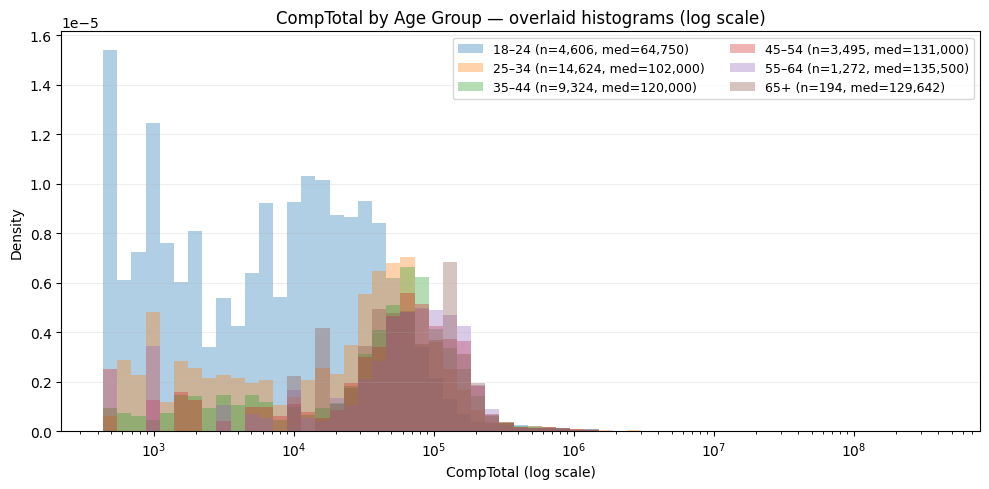

In [14]:
## Write your code here
#option 1:  Overlaid histograms of CompTotal by Age group — log scale (recommended)
import sqlite3, pandas as pd, numpy as np, matplotlib.pyplot as plt

# Load only what's needed
conn = sqlite3.connect("survey-data.sqlite")
q = """
SELECT CAST(CompTotal AS REAL) AS comp, CAST(Age AS REAL) AS Age
FROM main
WHERE CompTotal IS NOT NULL AND TRIM(CAST(CompTotal AS TEXT)) <> ''
  AND CAST(CompTotal AS REAL) > 0
  AND Age IS NOT NULL AND TRIM(CAST(Age AS TEXT)) <> ''
"""
df = pd.read_sql_query(q, conn)
conn.close()

# Light cleaning
df["comp"] = pd.to_numeric(df["comp"], errors="coerce")
df["Age"]  = pd.to_numeric(df["Age"],  errors="coerce")
df = df.dropna(subset=["comp","Age"])
df = df[df["Age"].between(18, 80)]

# Age groups
age_bins   = [18,25,35,45,55,65,120]
age_labels = ["18–24","25–34","35–44","45–54","55–64","65+"]
df["AgeGroup"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels,
                        right=False, include_lowest=True)

# Log-spaced bins over common central range
xmin = df["comp"].quantile(0.005)
xmax = df["comp"].quantile(0.995)
xbins = np.logspace(np.log10(xmin), np.log10(xmax), 60)

# One plot, overlaid
fig, ax = plt.subplots(figsize=(10,5))
for g in age_labels:
    sub = df.loc[df["AgeGroup"] == g, "comp"]
    if sub.empty: continue
    ax.hist(sub, bins=xbins, density=True, alpha=0.35, linewidth=0.7,
            label=f"{g} (n={len(sub):,}, med={sub.median():,.0f})")

ax.set_xscale("log")
ax.set_title("CompTotal by Age Group — overlaid histograms (log scale)")
ax.set_xlabel("CompTotal (log scale)")
ax.set_ylabel("Density")
ax.legend(ncols=2, fontsize=9)
ax.grid(axis="y", which="both", alpha=0.2)
plt.tight_layout(); plt.show()


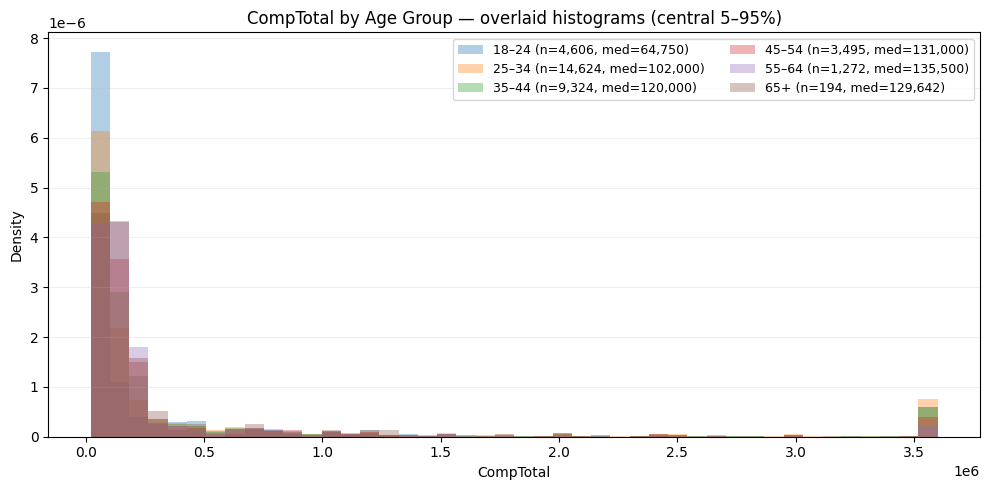

In [15]:
# option 2: Same plot on linear axis — trimmed to central 5–95%
lo, hi = df["comp"].quantile([0.05, 0.95])
df["comp_clip"] = df["comp"].clip(lo, hi)
bin_edges = np.linspace(lo, hi, 45)

fig, ax = plt.subplots(figsize=(10,5))
for g in age_labels:
    sub = df.loc[df["AgeGroup"] == g, "comp_clip"]
    if sub.empty: continue
    med = df.loc[df["AgeGroup"] == g, "comp"].median()
    ax.hist(sub, bins=bin_edges, density=True, alpha=0.35, linewidth=0.7,
            label=f"{g} (n={len(sub):,}, med={med:,.0f})")

ax.set_title("CompTotal by Age Group — overlaid histograms (central 5–95%)")
ax.set_xlabel("CompTotal")
ax.set_ylabel("Density")
ax.legend(ncols=2, fontsize=9)
ax.grid(axis="y", alpha=0.2)
plt.tight_layout(); plt.show()

**2.2 Histogram of TimeSearching for Different Age Groups**


Objective: Use histograms to explore the distribution of `TimeSearching` (time spent searching for information) for respondents across different age groups.


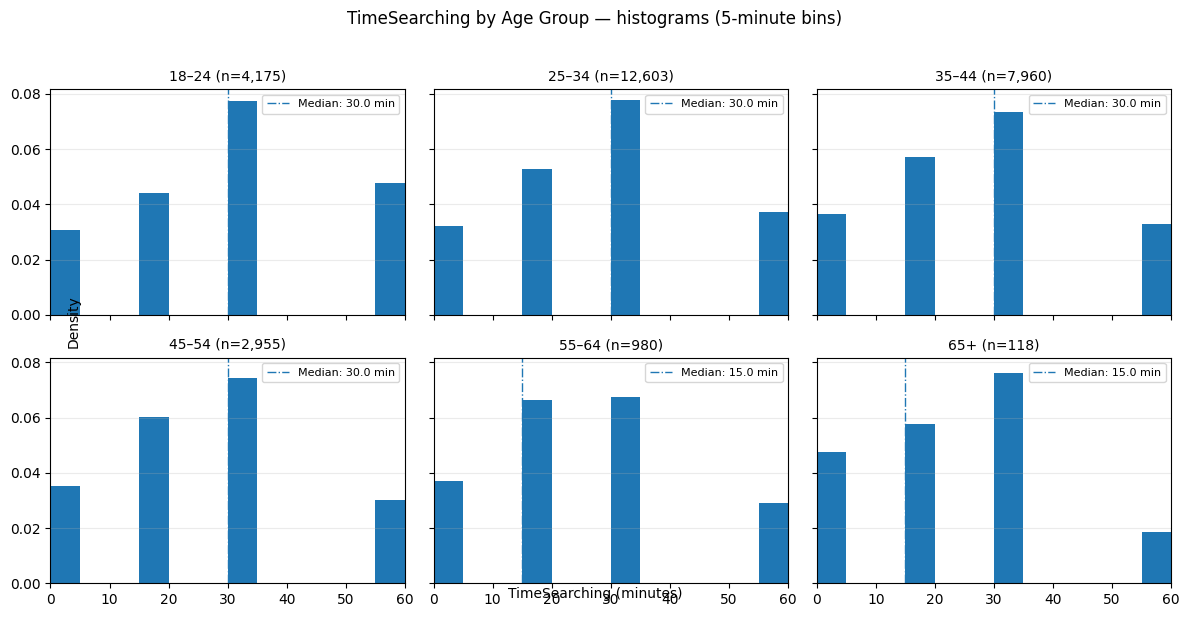

In [16]:
## Write your code here


import sqlite3, pandas as pd, numpy as np, matplotlib.pyplot as plt

# --- 1) SQL: extract just what we need ---
conn = sqlite3.connect("survey-data.sqlite")
QUERY = """
SELECT CAST(Age AS REAL) AS Age,
       CAST(TimeSearching AS REAL) AS TimeSearching
FROM main
WHERE Age IS NOT NULL AND TRIM(CAST(Age AS TEXT)) <> ''
  AND TimeSearching IS NOT NULL AND TRIM(CAST(TimeSearching AS TEXT)) <> ''
"""
df = pd.read_sql_query(QUERY, conn)
conn.close()

# --- 2) Light cleaning ---
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
df["TimeSearching"] = pd.to_numeric(df["TimeSearching"], errors="coerce")
df = df.dropna(subset=["Age", "TimeSearching"])
df = df[df["Age"].between(18, 80) & (df["TimeSearching"] >= 0)]

# Age groups
age_bins   = [18, 25, 35, 45, 55, 65, 120]
age_labels = ["18–24", "25–34", "35–44", "45–54", "55–64", "65+"]
df["AgeGroup"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels,
                        right=False, include_lowest=True)
df = df.dropna(subset=["AgeGroup"])

# --- 3) Common range & bins (5-minute bins; cap extreme tail for readability) ---
upper = min(df["TimeSearching"].quantile(0.99), 90)  # adjust cap if your class needs different
df["TS_clip"] = df["TimeSearching"].clip(0, upper)
bin_edges = np.arange(0, np.ceil(upper/5)*5 + 5, 5)   # 0,5,10,...,upper

# --- 4) Small-multiples histograms (shared axes) ---
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
axes = axes.ravel()

for ax, label in zip(axes, age_labels):
    sub = df.loc[df["AgeGroup"] == label, "TS_clip"]
    if sub.empty:
        ax.set_visible(False)
        continue
    # histogram (density) + median line (use original, not clipped)
    ax.hist(sub, bins=bin_edges, density=True)
    med = df.loc[df["AgeGroup"] == label, "TimeSearching"].median()
    ax.axvline(med, linestyle="-.", linewidth=1, label=f"Median: {med:.1f} min")
    ax.set_title(f"{label} (n={len(sub):,})", fontsize=10)
    ax.grid(axis="y", alpha=0.25)
    ax.legend(fontsize=8)

# common formatting
for ax in axes:
    if ax.get_visible():
        ax.set_xlim(0, upper)
        ax.set_xticks(np.arange(0, upper+1, 10))

fig.suptitle("TimeSearching by Age Group — histograms (5-minute bins)", y=1.02, fontsize=12)
fig.text(0.5, 0.04, "TimeSearching (minutes)", ha="center")
fig.text(0.06, 0.5, "Density", va="center", rotation="vertical")
plt.tight_layout()
plt.show()

### 3. Visualizing the Composition of Data


**3.1 Histogram of Most Desired Databases (`DatabaseWantToWorkWith`)**


Objective: Visualize the most desired databases for future learning using a histogram of the top 5 databases.


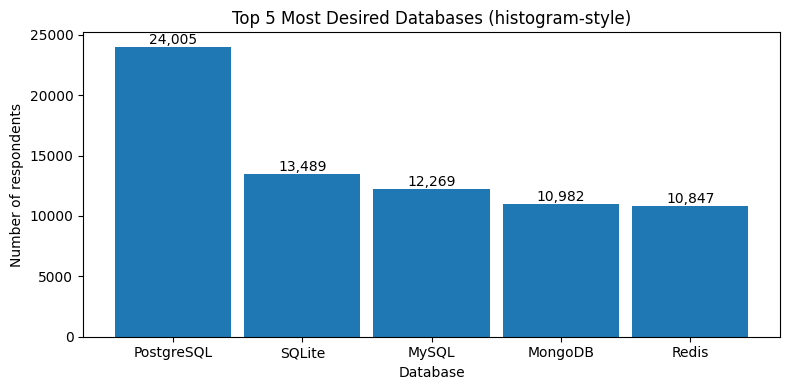

In [17]:
## Write your code here
# %%
# Task 3.1 — "Histogram" of Top 5 Most Desired Databases (categorical)
import sqlite3, pandas as pd, numpy as np, matplotlib.pyplot as plt

# 1) SQL: pull the multi-select column
conn = sqlite3.connect("survey-data.sqlite")
QUERY = """
SELECT DatabaseWantToWorkWith
FROM main
WHERE DatabaseWantToWorkWith IS NOT NULL
  AND TRIM(DatabaseWantToWorkWith) <> ''
"""
raw = pd.read_sql_query(QUERY, conn)
conn.close()

# 2) Split multi-select -> rows, trim, minimal normalization
dbs = (raw["DatabaseWantToWorkWith"].astype(str).str.split(";"))
dbs = pd.Series(np.concatenate(dbs.values)).str.strip()
dbs = dbs[dbs != ""]
dbs = dbs.replace({
    "Postgres": "PostgreSQL",
    "MS SQL Server": "SQL Server",
    "Microsoft SQL Server": "SQL Server",
    "Sqlite": "SQLite",
})

# 3) Top-5 counts
counts = dbs.value_counts()
top5 = counts.head(5)
labels = top5.index.tolist()
vals   = top5.values

# 4) Histogram-style plot with plt.hist (categorical encoded → bins)
x = np.arange(len(labels))                     # category codes: 0..4
bins = np.arange(-0.5, len(labels) + 0.5, 1)   # bin per category

fig, ax = plt.subplots(figsize=(8,4))
ax.hist(x, bins=bins, weights=vals, rwidth=0.9)  # weights=counts → bar heights
ax.set_title("Top 5 Most Desired Databases (histogram-style)")
ax.set_xlabel("Database")
ax.set_ylabel("Number of respondents")
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)

# annotate counts
for i, c in enumerate(vals):
    ax.text(i, c, f"{c:,}", ha="center", va="bottom")

plt.tight_layout(); plt.show()

**3.2 Histogram of Preferred Work Locations (`RemoteWork`)**


Objective: Use a histogram to explore the distribution of preferred work arrangements (`remote work`).


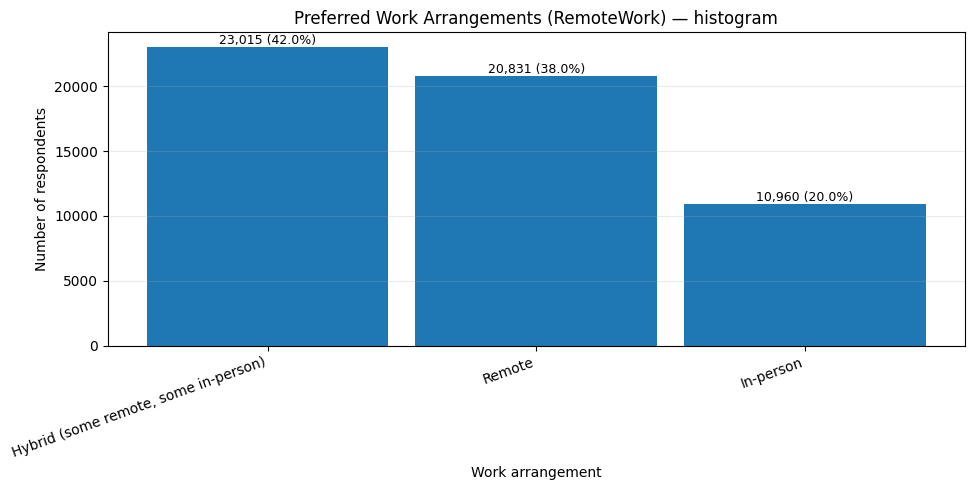

In [18]:
## Write your code here

# Task 3.2 — Histogram of Preferred Work Locations (RemoteWork)

import sqlite3, pandas as pd, numpy as np, matplotlib.pyplot as plt

# 1) SQL: pull the column
conn = sqlite3.connect("survey-data.sqlite")
QUERY = """
SELECT RemoteWork
FROM main
WHERE RemoteWork IS NOT NULL
  AND TRIM(RemoteWork) <> ''
"""
s = pd.read_sql_query(QUERY, conn)["RemoteWork"].astype(str)
conn.close()

# 2) Light cleaning
s = (s.str.strip()
     .str.replace(r"\s+", " ", regex=True))  # collapse excessive spaces

# (Optional) minimal normalization — uncomment/edit if your labels vary a lot
# s = s.replace({
#     "Hybrid (some remote, some in-person)": "Hybrid",
#     "Hybrid (remote and in-person)": "Hybrid",
#     "Full-time in-person": "In-person",
#     "Fully remote": "Remote",
# })

# 3) Counts (all categories)
counts = s.value_counts()
labels = counts.index.tolist()
vals   = counts.values

# 4) Histogram-style plot using category codes + weights
x = np.arange(len(labels))                         # 0..K-1
bins = np.arange(-0.5, len(labels) + 0.5, 1)       # one bin per category

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(x, bins=bins, weights=vals, rwidth=0.9)    # heights = counts

ax.set_title("Preferred Work Arrangements (RemoteWork) — histogram")
ax.set_xlabel("Work arrangement")
ax.set_ylabel("Number of respondents")
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=20, ha="right")

# annotate counts + %
total = vals.sum()
for i, c in enumerate(vals):
    ax.text(i, c, f"{c:,} ({c/total:.1%})", ha="center", va="bottom", fontsize=9)

ax.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


### 4. Visualizing Comparison of Data



**4.1 Histogram of Median CompTotal for Ages 45 to 60**


Objective: Plot the histogram for `CompTotal` within the age group 45 to 60 to analyze compensation distribution among mid-career respondents.


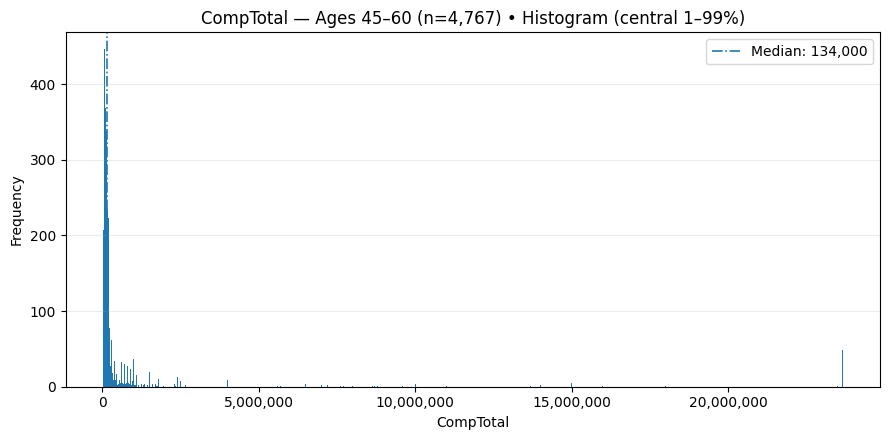

In [19]:
## Write your code here
# %%
# Task 4.1 — Histogram of CompTotal (Ages 45–60)

import sqlite3, pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 1) SQL: pull just what we need, already filtering Age 45–60 and positive comp
conn = sqlite3.connect("survey-data.sqlite")
QUERY = """
SELECT CAST(CompTotal AS REAL) AS CompTotal,
       CAST(Age       AS REAL) AS Age
FROM main
WHERE CompTotal IS NOT NULL AND TRIM(CAST(CompTotal AS TEXT)) <> ''
  AND CAST(CompTotal AS REAL) > 0
  AND Age IS NOT NULL AND TRIM(CAST(Age AS TEXT)) <> ''
  AND CAST(Age AS REAL) BETWEEN 45 AND 60
"""
df = pd.read_sql_query(QUERY, conn)
conn.close()

# 2) Defensive casting & NA drop
df["CompTotal"] = pd.to_numeric(df["CompTotal"], errors="coerce")
df = df.dropna(subset=["CompTotal"])

# 3) Light winsorization for readability (central 1–99%)
p01, p99 = df["CompTotal"].quantile([0.01, 0.99])
x = df["CompTotal"].clip(p01, p99)
median_val = df["CompTotal"].median()   # median on unclipped values
n = len(df)

# 4) Histogram (FD bins) + median line
fig, ax = plt.subplots(figsize=(9, 4.5))
ax.hist(x, bins="fd")
ax.axvline(median_val, linestyle="-.", linewidth=1.2, label=f"Median: {median_val:,.0f}")

ax.set_title(f"CompTotal — Ages 45–60 (n={n:,}) • Histogram (central 1–99%)")
ax.set_xlabel("CompTotal")
ax.set_ylabel("Frequency")
ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{int(v):,}"))
ax.grid(axis="y", alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()

# (Optional) If your instructor prefers keeping all values, use a log-scale view:
# fig, ax = plt.subplots(figsize=(9, 4.5))
# ax.hist(np.log10(df["CompTotal"]), bins=50)
# ax.set_title("CompTotal — Ages 45–60 (log10 scale, all data)")
# ax.set_xlabel("log10(CompTotal)")
# ax.set_ylabel("Frequency")
# plt.tight_layout(); plt.show()

**4.2 Histogram of Job Satisfaction (`JobSat`) by YearsCodePro**


Objective: Plot the histogram for `JobSat` scores based on respondents' years of professional coding experience.


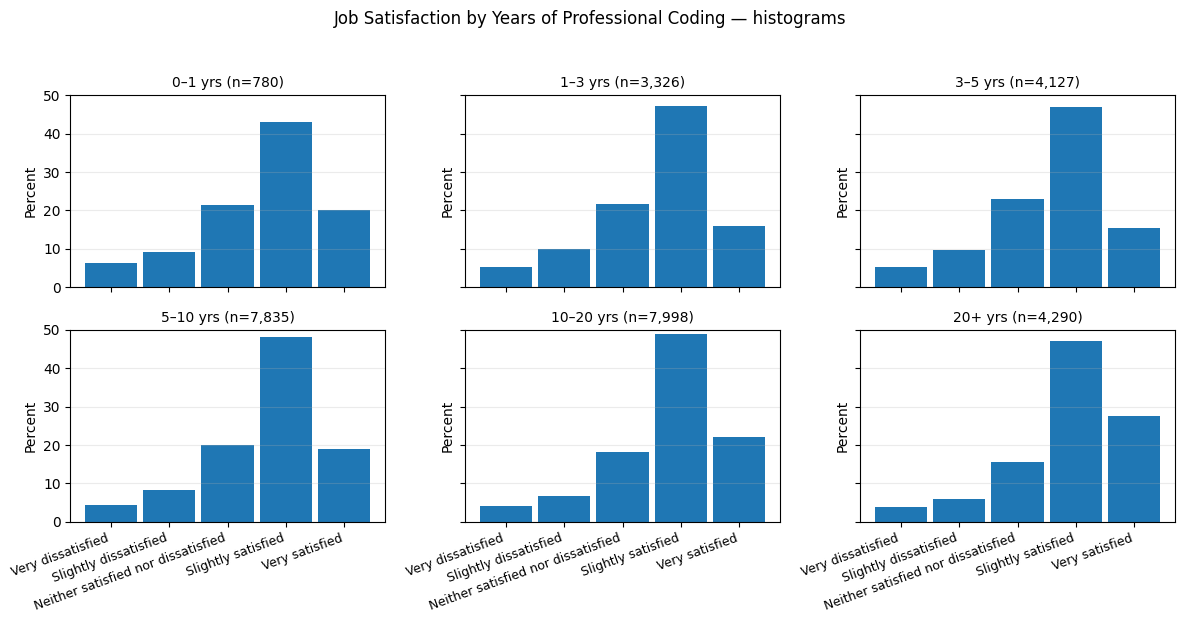

In [20]:
## Write your code here

# Task 4.2 — Histogram of JobSat by YearsCodePro (robust to label variants)

import sqlite3, pandas as pd, numpy as np, matplotlib.pyplot as plt

# ---------- 1) SQL ----------
conn = sqlite3.connect("survey-data.sqlite")
QUERY = """
SELECT JobSat, YearsCodePro
FROM main
WHERE JobSat IS NOT NULL AND TRIM(JobSat) <> ''
  AND YearsCodePro IS NOT NULL AND TRIM(YearsCodePro) <> ''
"""
df = pd.read_sql_query(QUERY, conn)
conn.close()

# ---------- 2) YearsCodePro -> numeric & bands ----------
yrs = (df["YearsCodePro"].astype(str).str.strip()
       .replace({"Less than 1 year": 0.5, "More than 50 years": 55}))
yrs = pd.to_numeric(yrs, errors="coerce")
df = df.assign(YearsCodePro=yrs).dropna(subset=["YearsCodePro"])
df = df[df["YearsCodePro"].between(0, 60)]

bands   = [0, 1, 3, 5, 10, 20, 60]
labels  = ["0–1", "1–3", "3–5", "5–10", "10–20", "20+"]
df["YearsBand"] = pd.cut(df["YearsCodePro"], bins=bands, labels=labels,
                         right=False, include_lowest=True)

# ---------- 3) JobSat normalization ----------
order = [
    "Very dissatisfied",
    "Slightly dissatisfied",
    "Neither satisfied nor dissatisfied",
    "Slightly satisfied",
    "Very satisfied",
]

def jobsat_to_5bin(val):
    s = str(val).strip().lower()
    # text-based buckets
    if "very dissat" in s or "extremely dissat" in s or "strongly disagree" in s:
        return "Very dissatisfied"
    if "slightly dissat" in s or "somewhat dissat" in s:
        return "Slightly dissatisfied"
    if "neither" in s or "neutral" in s:
        return "Neither satisfied nor dissatisfied"
    if "slightly sat" in s or "somewhat sat" in s or ("agree" in s and "strongly" not in s):
        return "Slightly satisfied"
    if "very sat" in s or "extremely sat" in s or "strongly agree" in s:
        return "Very satisfied"
    # numeric 1–10 fallback
    num = pd.to_numeric(s, errors="coerce")
    if pd.notna(num):
        if num <= 2:  return "Very dissatisfied"
        if num <= 4:  return "Slightly dissatisfied"
        if num <= 6:  return "Neither satisfied nor dissatisfied"
        if num <= 8:  return "Slightly satisfied"
        return "Very satisfied"
    return None  # unrecognized → drop

df["JobSatNorm"] = df["JobSat"].map(jobsat_to_5bin)
df = df.dropna(subset=["JobSatNorm"])

# If still nothing, quickly inspect what labels look like:
# print(df["JobSat"].astype(str).str.lower().value_counts().head(20))

# ---------- 4) Histogram-style bins (categorical via indices) ----------
xcodes = np.arange(len(order))
edges  = np.arange(-0.5, len(order) + 0.5, 1)

# ---------- 5) Small-multiples histograms (percent within each band) ----------
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
axes = axes.ravel()

max_pct = 0
for ax, band in zip(axes, labels):
    sub = df.loc[df["YearsBand"] == band, "JobSatNorm"]
    counts = sub.value_counts().reindex(order, fill_value=0).values
    total  = counts.sum()

    if total == 0:
        ax.hist([], bins=edges)
        ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
        ax.set_title(f"{band} yrs (n=0)", fontsize=10)
    else:
        weights = counts / total * 100.0
        max_pct = max(max_pct, weights.max())
        ax.hist(xcodes, bins=edges, weights=weights, rwidth=0.9)
        ax.set_title(f"{band} yrs (n={int(total):,})", fontsize=10)

    ax.set_xticks(xcodes)
    ax.set_xticklabels(order, rotation=20, ha="right", fontsize=9)
    ax.set_ylabel("Percent")
    ax.grid(axis="y", alpha=0.25)

for ax in axes:
    ax.set_ylim(0, max(20, np.ceil(max_pct/5)*5))

fig.suptitle("Job Satisfaction by Years of Professional Coding — histograms", y=1.03, fontsize=12)
plt.tight_layout()
plt.show()

### Final step: Close the database connection


Once you've completed the lab, make sure to close the connection to the SQLite database:



In [21]:
conn.close()

### Summary


In this lab, you used histograms to visualize various aspects of the dataset, focusing on:

- Distribution of compensation, coding experience, and work hours.

- Relationships in compensation across age groups and work status.

- Composition of data by desired databases and work environments.

- Comparisons of job satisfaction across years of experience.

Histograms helped reveal patterns and distributions in the data, enhancing your understanding of developer demographics and preferences.


## Authors:
Ayushi Jain


### Other Contributors:
- Rav Ahuja
- Lakshmi Holla
- Malika


Copyright © IBM Corporation. All rights reserved.
